### Dataset Exploration

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Attention, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW

In [4]:
cs5814_mbti_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/mbti_500.csv')
cs5814_mbti_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106067 entries, 0 to 106066
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   posts           106067 non-null  object 
 1   type            106067 non-null  object 
 2   filtered_posts  106066 non-null  object 
 3   cEXT            106067 non-null  float64
 4   cAGR            106067 non-null  float64
 5   cCON            106067 non-null  float64
 6   cOPN            106067 non-null  float64
dtypes: float64(4), object(3)
memory usage: 5.7+ MB


<ipython-input-6-c13a4b886141>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


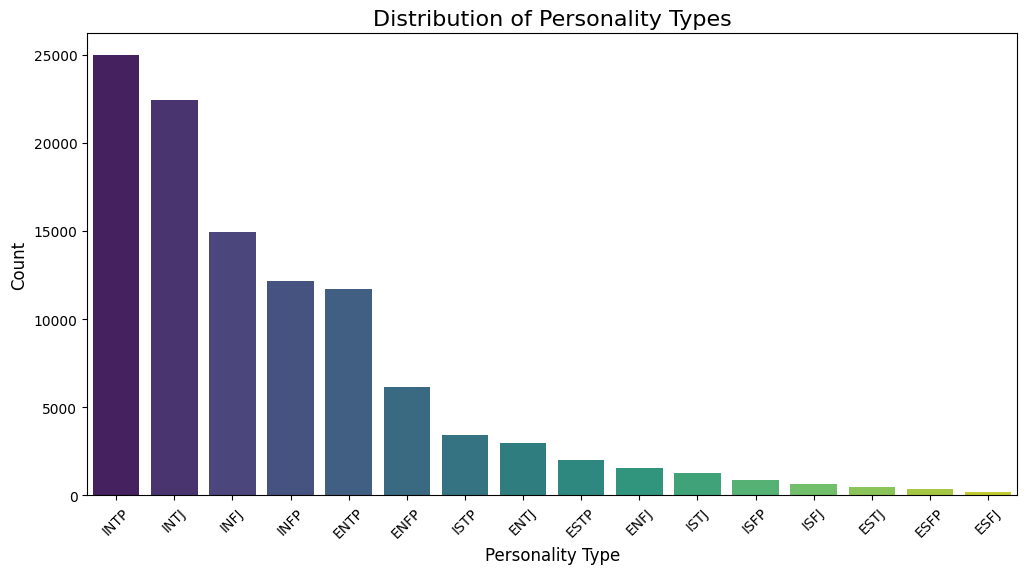

Class Distribution:
 type
INTP    24960
INTJ    22427
INFJ    14963
INFP    12134
ENTP    11725
ENFP     6167
ISTP     3424
ENTJ     2955
ESTP     1986
ENFJ     1534
ISTJ     1243
ISFP      875
ISFJ      650
ESTJ      482
ESFP      360
ESFJ      181
Name: count, dtype: int64


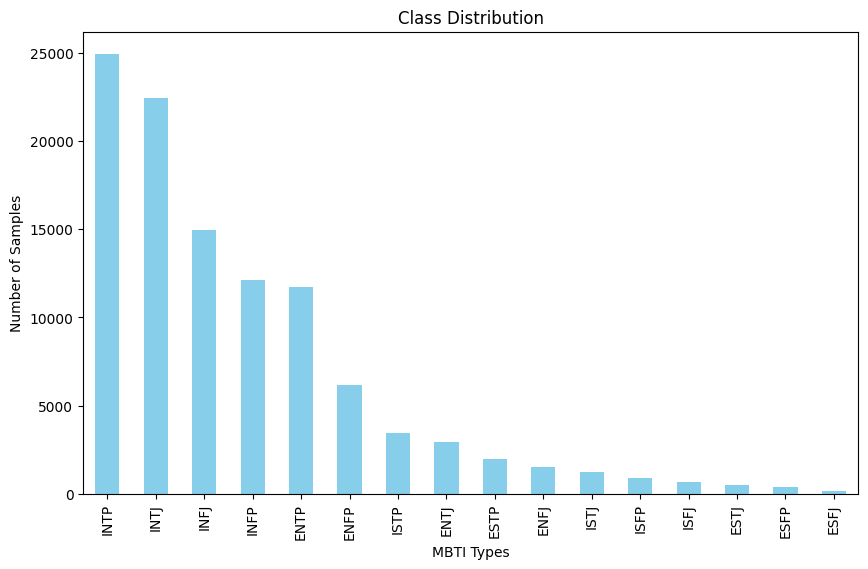

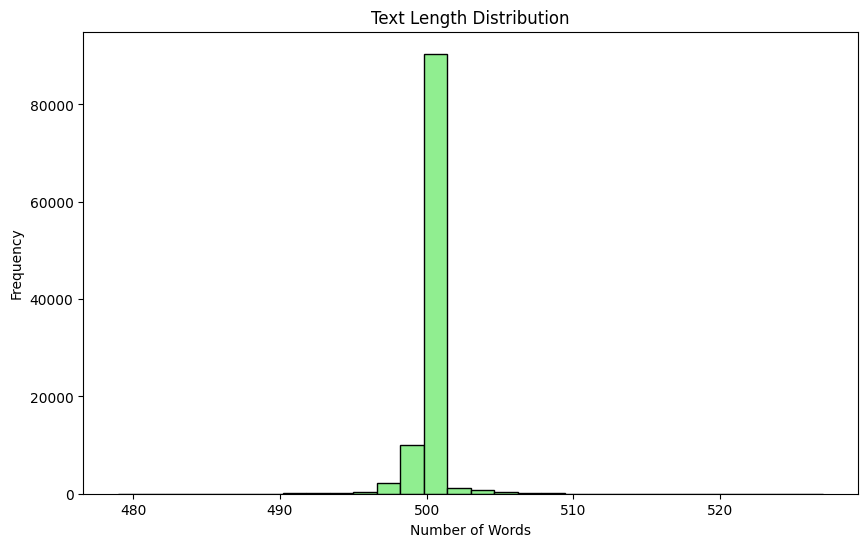

In [6]:
plt.figure(figsize=(12, 6))
sns.countplot(
    x='type',
    data=cs5814_mbti_df,
    order=cs5814_mbti_df['type'].value_counts().index,
    palette='viridis'
)
plt.title("Distribution of Personality Types", fontsize=16)
plt.xlabel("Personality Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.show()

cs5814_mbti_df = cs5814_mbti_df.dropna()

cs5814_class_distribution = cs5814_mbti_df['type'].value_counts()
print("Class Distribution:\n", cs5814_class_distribution)

plt.figure(figsize=(10, 6))
cs5814_class_distribution.plot(kind='bar', color='skyblue')
plt.title("Class Distribution")
plt.xlabel("MBTI Types")
plt.ylabel("Number of Samples")
plt.show()

cs5814_text_lengths = cs5814_mbti_df['posts'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10, 6))
plt.hist(cs5814_text_lengths, bins=30, color='lightgreen', edgecolor='black')
plt.title("Text Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

#### Balancing the dataset using SMOTE

Balanced Class Distribution:
 type
INTJ    24960
INTP    24960
ISFJ    24960
ISFP    24960
ISTJ    24960
ISTP    24960
ENFJ    24960
ENFP    24960
ENTJ    24960
ENTP    24960
ESFJ    24960
ESFP    24960
ESTJ    24960
ESTP    24960
INFJ    24960
INFP    24960
Name: count, dtype: int64


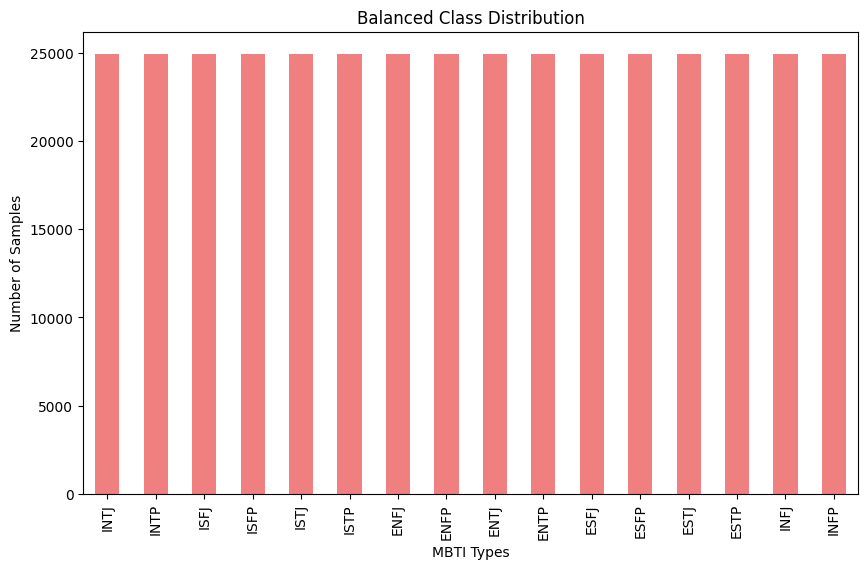

In [9]:
cs5814_texts = cs5814_mbti_df['posts']
cs5814_labels = cs5814_mbti_df['type']

cs5814_unique_labels = sorted(cs5814_labels.unique())
cs5814_label_to_idx = {label: idx for idx, label in enumerate(cs5814_unique_labels)}
cs5814_idx_to_label = {idx: label for label, idx in cs5814_label_to_idx.items()}
cs5814_encoded_labels = np.array([cs5814_label_to_idx[label] for label in cs5814_labels])

cs5814_ros = RandomOverSampler(random_state=42)
cs5814_X_resampled, cs5814_y_resampled = cs5814_ros.fit_resample(cs5814_texts.values.reshape(-1, 1), cs5814_encoded_labels)

cs5814_balanced_df = pd.DataFrame({
    'posts': cs5814_X_resampled.flatten(),
    'type': [cs5814_idx_to_label[label] for label in cs5814_y_resampled]
})

cs5814_balanced_class_distribution = cs5814_balanced_df['type'].value_counts()
print("Balanced Class Distribution:\n", cs5814_balanced_class_distribution)

plt.figure(figsize=(10, 6))
cs5814_balanced_class_distribution.plot(kind='bar', color='lightcoral')
plt.title("Balanced Class Distribution")
plt.xlabel("MBTI Types")
plt.ylabel("Number of Samples")
plt.show()

cs5814_balanced_df.to_csv('balanced_mbti_data.csv', index=False)

### Naive Bayes

In [10]:
cs5814_naive_bayes_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/balanced_mbti_data.csv')

cs5814_naive_bayes_texts = cs5814_naive_bayes_df['posts']
cs5814_naive_bayes_labels = cs5814_naive_bayes_df['type']

cs5814_naive_bayes_X_train, cs5814_naive_bayes_X_test, cs5814_naive_bayes_y_train, cs5814_naive_bayes_y_test = train_test_split(
    cs5814_naive_bayes_texts,
    cs5814_naive_bayes_labels,
    test_size=0.2,
    random_state=42
)

cs5814_naive_bayes_tfidf = TfidfVectorizer(max_features=2000, stop_words='english')
cs5814_naive_bayes_X_train_tfidf = cs5814_naive_bayes_tfidf.fit_transform(cs5814_naive_bayes_X_train)
cs5814_naive_bayes_X_test_tfidf = cs5814_naive_bayes_tfidf.transform(cs5814_naive_bayes_X_test)

cs5814_naive_bayes_model = MultinomialNB()
cs5814_naive_bayes_model.fit(cs5814_naive_bayes_X_train_tfidf, cs5814_naive_bayes_y_train)

cs5814_naive_bayes_y_pred = cs5814_naive_bayes_model.predict(cs5814_naive_bayes_X_test_tfidf)

print("Accuracy:", accuracy_score(cs5814_naive_bayes_y_test, cs5814_naive_bayes_y_pred))
print("\nClassification Report:\n")
print(classification_report(cs5814_naive_bayes_y_test, cs5814_naive_bayes_y_pred))


Accuracy: 0.7640725160256411

Classification Report:

              precision    recall  f1-score   support

        ENFJ       0.76      0.75      0.76      5002
        ENFP       0.64      0.75      0.69      4934
        ENTJ       0.86      0.77      0.81      5016
        ENTP       0.71      0.67      0.69      5022
        ESFJ       0.93      0.89      0.91      5043
        ESFP       0.84      0.90      0.87      4932
        ESTJ       0.97      0.79      0.87      5076
        ESTP       0.87      0.89      0.88      4920
        INFJ       0.69      0.67      0.68      5046
        INFP       0.60      0.64      0.62      5007
        INTJ       0.67      0.66      0.66      4945
        INTP       0.62      0.70      0.66      4972
        ISFJ       0.82      0.83      0.82      5073
        ISFP       0.72      0.81      0.76      4880
        ISTJ       0.80      0.79      0.79      5034
        ISTP       0.83      0.72      0.77      4970

    accuracy              

### LSTM

In [11]:


cs5814_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/balanced_mbti_data.csv')

cs5814_label_encoder = LabelEncoder()
cs5814_df['encoded_type'] = cs5814_label_encoder.fit_transform(cs5814_df['type'])

cs5814_train_texts, cs5814_test_texts, cs5814_y_train, cs5814_y_test = train_test_split(
    cs5814_df['posts'].values,  # Text data
    cs5814_df['encoded_type'].values,  # Encoded labels
    test_size=0.2,
    random_state=42
)

In [12]:
with open('cs5814_label_encoder.pkl', 'wb') as f:
    pickle.dump(cs5814_label_encoder, f)

cs5814_max_words = 20000
cs5814_max_len = 128

cs5814_tokenizer = Tokenizer(num_words=cs5814_max_words, oov_token="<OOV>")
cs5814_tokenizer.fit_on_texts(cs5814_train_texts)

cs5814_train_sequences = cs5814_tokenizer.texts_to_sequences(cs5814_train_texts)
cs5814_test_sequences = cs5814_tokenizer.texts_to_sequences(cs5814_test_texts)

cs5814_X_train_padded = pad_sequences(cs5814_train_sequences, maxlen=cs5814_max_len, padding='post')
cs5814_X_test_padded = pad_sequences(cs5814_test_sequences, maxlen=cs5814_max_len, padding='post')

with open('cs5814_tokenizer.pkl', 'wb') as f:
    pickle.dump(cs5814_tokenizer, f)
np.save('cs5814_X_train_padded.npy', cs5814_X_train_padded)
np.save('cs5814_X_test_padded.npy', cs5814_X_test_padded)
np.save('cs5814_y_train.npy', cs5814_y_train)
np.save('cs5814_y_test.npy', cs5814_y_test)

print("CS5814 Dataset loaded, tokenized, and saved!")

CS5814 Dataset loaded, tokenized, and saved!


In [13]:
with open('cs5814_tokenizer.pkl', 'rb') as f:
    cs5814_tokenizer = pickle.load(f)
cs5814_X_train_padded = np.load('cs5814_X_train_padded.npy')
cs5814_X_test_padded = np.load('cs5814_X_test_padded.npy')
cs5814_y_train = np.load('cs5814_y_train.npy')
cs5814_y_test = np.load('cs5814_y_test.npy')

cs5814_embedding_index = {}
with open('/content/drive/MyDrive/Colab Notebooks/Datasets/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        cs5814_values = line.split()
        cs5814_word = cs5814_values[0]
        cs5814_coefs = np.asarray(cs5814_values[1:], dtype='float32')
        cs5814_embedding_index[cs5814_word] = cs5814_coefs

cs5814_embedding_dim = 100
cs5814_embedding_matrix = np.zeros((cs5814_max_words, cs5814_embedding_dim))
for cs5814_word, cs5814_i in cs5814_tokenizer.word_index.items():
    if cs5814_i < cs5814_max_words:
        cs5814_embedding_vector = cs5814_embedding_index.get(cs5814_word)
        if cs5814_embedding_vector is not None:
            cs5814_embedding_matrix[cs5814_i] = cs5814_embedding_vector

print("CS5814 Preprocessed data and embeddings loaded successfully!")

CS5814 Preprocessed data and embeddings loaded successfully!


In [14]:


cs5814_lstm_model = Sequential([
    Embedding(input_dim=cs5814_max_words, output_dim=cs5814_embedding_dim, weights=[cs5814_embedding_matrix], input_length=cs5814_max_len, trainable=False),
    LSTM(128, return_sequences=False),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(cs5814_y_train)), activation='softmax')
])

cs5814_lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cs5814_early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

cs5814_history = cs5814_lstm_model.fit(
    cs5814_X_train_padded, cs5814_y_train,
    validation_data=(cs5814_X_test_padded, cs5814_y_test),
    epochs=10,
    batch_size=32,
    callbacks=[cs5814_early_stopping]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
9984/9984 ━━━━━━━━━━━━━━━━━━━━ 146s 14ms/step - accuracy: 0.1805 - loss: 2.4888 - val_accuracy: 0.4663 - val_loss: 1.6233
Epoch 2/10
9984/9984 ━━━━━━━━━━━━━━━━━━━━ 179s 18ms/step - accuracy: 0.4856 - loss: 1.5543 - val_accuracy: 0.5814 - val_loss: 1.2319
Epoch 3/10
9984/9984 ━━━━━━━━━━━━━━━━━━━━ 154s 13ms/step - accuracy: 0.5765 - loss: 1.2495 - val_accuracy: 0.6311 - val_loss: 1.0657
Epoch 4/10
9984/9984 ━━━━━━━━━━━━━━━━━━━━ 146s 14ms/step - accuracy: 0.6181 - loss: 1.1089 - val_accuracy: 0.6503 - val_loss: 0.9944
Epoch 5/10
9984/9984 ━━━━━━━━━━━━━━━━━━━━ 158s 15ms/step - accuracy: 0.6413 - loss: 1.0234 - val_accuracy: 0.6667 - val_loss: 0.9442
Epoch 6/10
9984/9984 ━━━━━━━━━━━━━━━━━━━━ 235s 18ms/step - accuracy: 0.6559 - loss: 0.9782 - val_accuracy: 0.6761 - val_loss: 0.9128
Epoch 7/10
9984/9984 ━━━━━━━━━━━━━━━━━━━━ 154s 14ms/step - accuracy: 0.6661 - loss: 0.9444 - val_accuracy: 0.6844 - val_loss: 0.8861
Epoch 8/10
9984/9984 ━━━━━━━━━━━━━━━━━━━━ 140s 14ms/step - accuracy: 

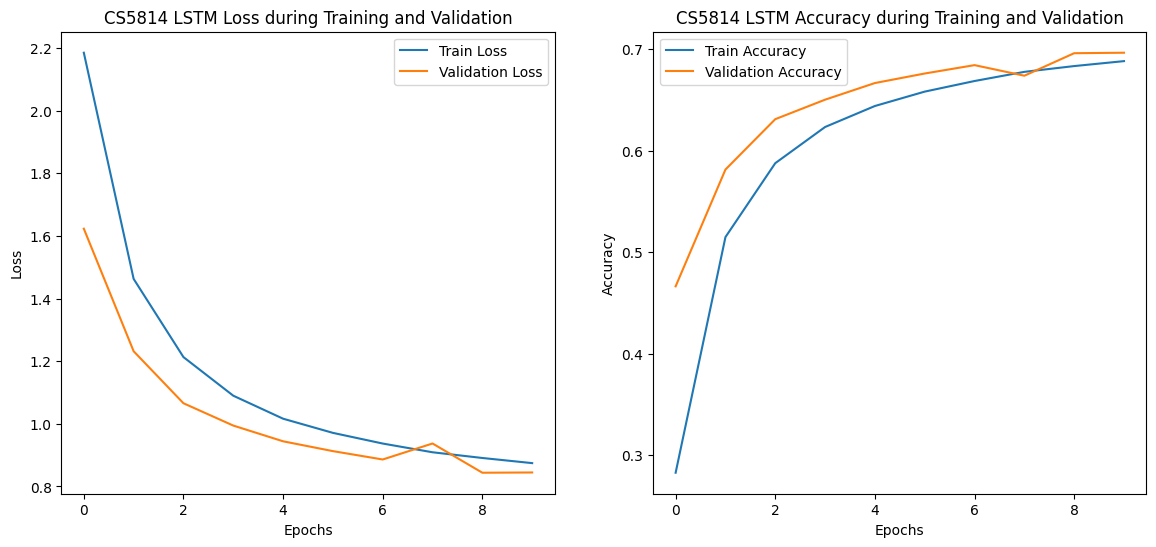

2496/2496 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step

CS5814 Classification Report:
              precision    recall  f1-score   support

        ENFJ       0.88      0.98      0.93      5002
        ENFP       0.37      0.40      0.38      4934
        ENTJ       0.64      0.81      0.72      5016
        ENTP       0.35      0.29      0.31      5022
        ESFJ       1.00      1.00      1.00      5043
        ESFP       0.98      1.00      0.99      4932
        ESTJ       0.99      1.00      0.99      5076
        ESTP       0.93      0.98      0.96      4920
        INFJ       0.26      0.28      0.27      5046
        INFP       0.36      0.16      0.22      5007
        INTJ       0.41      0.36      0.38      4945
        INTP       0.25      0.20      0.22      4972
        ISFJ       0.97      0.99      0.98      5073
        ISFP       0.94      1.00      0.97      4880
        ISTJ       0.88      0.99      0.93      5034
        ISTP       0.57      0.70      0.63      4970

    a

In [15]:


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(cs5814_history.history['loss'], label='Train Loss')
plt.plot(cs5814_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('CS5814 LSTM Loss during Training and Validation')

plt.subplot(1, 2, 2)
plt.plot(cs5814_history.history['accuracy'], label='Train Accuracy')
plt.plot(cs5814_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('CS5814 LSTM Accuracy during Training and Validation')

plt.show()

cs5814_y_pred = cs5814_lstm_model.predict(cs5814_X_test_padded)
cs5814_y_pred_classes = np.argmax(cs5814_y_pred, axis=1)

print("\nCS5814 Classification Report:")
print(classification_report(cs5814_y_test, cs5814_y_pred_classes, target_names=cs5814_label_encoder.classes_))


###Bi-Lstm

Shape of y_train: (319488, 16)
Epoch 1/10
7988/7988 ━━━━━━━━━━━━━━━━━━━━ 169s 20ms/step - accuracy: 0.3938 - loss: 1.8413 - val_accuracy: 0.7841 - val_loss: 0.6727
Epoch 2/10
7988/7988 ━━━━━━━━━━━━━━━━━━━━ 195s 20ms/step - accuracy: 0.8068 - loss: 0.6041 - val_accuracy: 0.8415 - val_loss: 0.4855
Epoch 3/10
7988/7988 ━━━━━━━━━━━━━━━━━━━━ 198s 19ms/step - accuracy: 0.8691 - loss: 0.4024 - val_accuracy: 0.8669 - val_loss: 0.4154
Epoch 4/10
7988/7988 ━━━━━━━━━━━━━━━━━━━━ 225s 22ms/step - accuracy: 0.9059 - loss: 0.2894 - val_accuracy: 0.8797 - val_loss: 0.3919
Epoch 5/10
7988/7988 ━━━━━━━━━━━━━━━━━━━━ 202s 22ms/step - accuracy: 0.9294 - loss: 0.2173 - val_accuracy: 0.8868 - val_loss: 0.3929
Epoch 6/10
7988/7988 ━━━━━━━━━━━━━━━━━━━━ 204s 22ms/step - accuracy: 0.9459 - loss: 0.1695 - val_accuracy: 0.8934 - val_loss: 0.4120
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 4.
2496/2496 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step

Classification Report for Bi-LSTM:
        

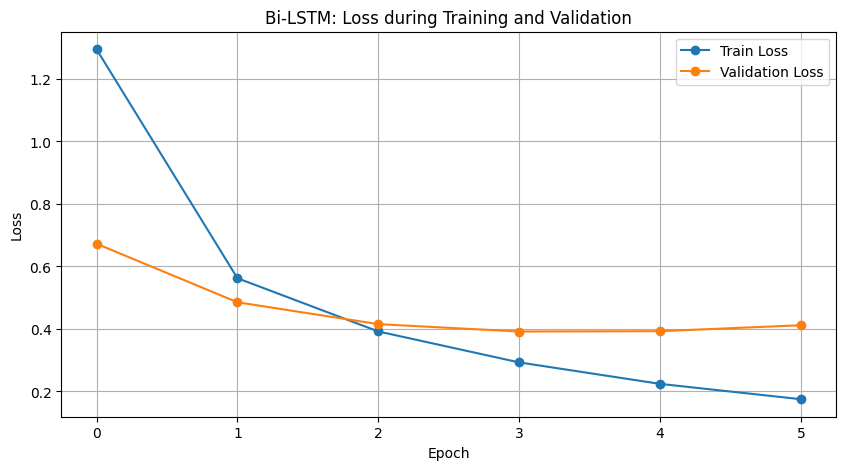

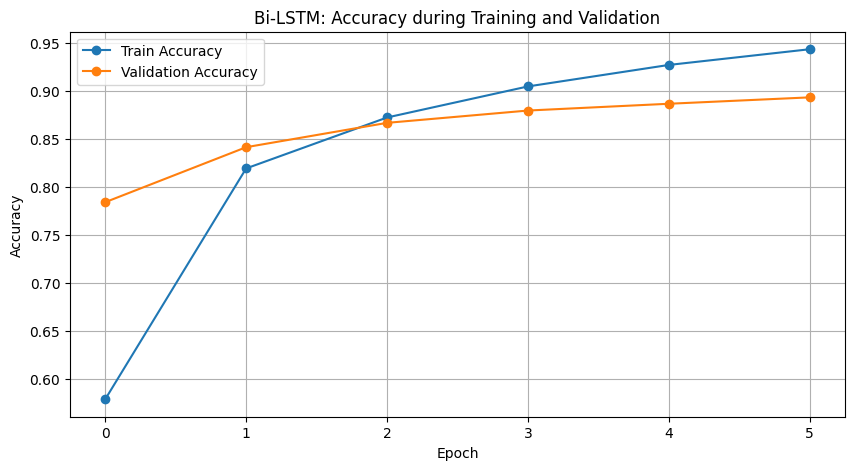

In [18]:
print("Shape of y_train:", cs5814_y_train.shape)

if len(cs5814_y_train.shape) == 1 or cs5814_y_train.ndim == 1:
    cs5814_y_train = to_categorical(cs5814_y_train, num_classes=len(cs5814_label_encoder.classes_))
    cs5814_y_test = to_categorical(cs5814_y_test, num_classes=len(cs5814_label_encoder.classes_))

cs5814_bilstm_model = Sequential([
    Embedding(input_dim=cs5814_max_words, output_dim=100, weights=[cs5814_embedding_matrix],
              input_length=cs5814_X_train_padded.shape[1], trainable=True),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(cs5814_y_train.shape[1], activation='softmax')
])

cs5814_bilstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cs5814_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

cs5814_bilstm_history = cs5814_bilstm_model.fit(
    cs5814_X_train_padded, cs5814_y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    verbose=1,
    callbacks=[cs5814_early_stopping]
)

cs5814_y_pred = cs5814_bilstm_model.predict(cs5814_X_test_padded)
cs5814_y_pred_classes = np.argmax(cs5814_y_pred, axis=1)
cs5814_y_true_classes = np.argmax(cs5814_y_test, axis=1)

print("\nClassification Report for Bi-LSTM:")
print(classification_report(cs5814_y_true_classes, cs5814_y_pred_classes, target_names=cs5814_label_encoder.classes_))

plt.figure(figsize=(10, 5))
plt.plot(cs5814_bilstm_history.history['loss'], marker='o', label='Train Loss')
plt.plot(cs5814_bilstm_history.history['val_loss'], marker='o', label='Validation Loss')
plt.title('Bi-LSTM: Loss during Training and Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(cs5814_bilstm_history.history['accuracy'], marker='o', label='Train Accuracy')
plt.plot(cs5814_bilstm_history.history['val_accuracy'], marker='o', label='Validation Accuracy')
plt.title('Bi-LSTM: Accuracy during Training and Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


###BiLSTM + Attention Mechanism

In [20]:
cs5814_df_balanced = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Datasets/balanced_mbti_data.csv")
cs5814_texts = cs5814_df_balanced['posts']
cs5814_labels = pd.get_dummies(cs5814_df_balanced['type']).values

cs5814_max_words = 20000
cs5814_embedding_dim = 300
cs5814_max_len = 500
cs5814_batch_size = 32
cs5814_epochs = 10

cs5814_embeddings_index = {}
with open('/content/drive/MyDrive/Colab Notebooks/Datasets/glove.6B.300d.txt', encoding='utf-8') as f:
    for line in f:
        cs5814_values = line.split()
        cs5814_word = cs5814_values[0]
        cs5814_coefs = np.asarray(cs5814_values[1:], dtype='float32')
        cs5814_embeddings_index[cs5814_word] = cs5814_coefs


In [21]:
cs5814_tokenizer = Tokenizer(num_words=cs5814_max_words, oov_token="<OOV>")
cs5814_tokenizer.fit_on_texts(cs5814_texts)
cs5814_sequences = cs5814_tokenizer.texts_to_sequences(cs5814_texts)
cs5814_word_index = cs5814_tokenizer.word_index

cs5814_X = pad_sequences(cs5814_sequences, maxlen=cs5814_max_len, padding='post')
cs5814_y = np.array(cs5814_labels)

cs5814_X_train, cs5814_X_test, cs5814_y_train, cs5814_y_test = train_test_split(
    cs5814_X, cs5814_y, test_size=0.2, random_state=42
)

cs5814_embedding_matrix = np.zeros((cs5814_max_words, cs5814_embedding_dim))
for cs5814_word, cs5814_i in cs5814_word_index.items():
    if cs5814_i < cs5814_max_words:
        cs5814_embedding_vector = cs5814_embeddings_index.get(cs5814_word)
        if cs5814_embedding_vector is not None:
            cs5814_embedding_matrix[cs5814_i] = cs5814_embedding_vector

In [22]:
cs5814_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=1,
    restore_best_weights=True
)

cs5814_input = Input(shape=(cs5814_max_len,))
cs5814_embedding = Embedding(input_dim=cs5814_max_words, output_dim=cs5814_embedding_dim,
                              input_length=cs5814_max_len, weights=[cs5814_embedding_matrix],
                              trainable=True)(cs5814_input)
cs5814_dropout1 = Dropout(0.3)(cs5814_embedding)
cs5814_bilstm = Bidirectional(LSTM(128, return_sequences=True))(cs5814_dropout1)
cs5814_attention = Attention()([cs5814_bilstm, cs5814_bilstm])
cs5814_lstm = LSTM(128)(cs5814_attention)
cs5814_dropout2 = Dropout(0.3)(cs5814_lstm)
cs5814_dense = Dense(128, activation='relu')(cs5814_dropout2)
cs5814_dropout3 = Dropout(0.3)(cs5814_dense)
cs5814_output = Dense(cs5814_y_train.shape[1], activation='softmax')(cs5814_dropout3)
cs5814_model = Model(inputs=cs5814_input, outputs=cs5814_output)

cs5814_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cs5814_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 500)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, 500, 300)       │      6,000,000 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 500, 300)       │              0 │ embedding_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 500, 256)       │        439,296 │ dropout_6[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 500, 256)       │              0 │ bidirectional_2[0][0], │
│                           │                        │                │ bidirectional_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ (None, 128)            │        197,120 │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 128)            │              0 │ lstm_4[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 128)            │         16,512 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 128)            │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 16)             │          2,064 │ dropout_8[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,654,992 (25.39 MB)

 Trainable params: 6,654,992 (25.39 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
7988/7988 ━━━━━━━━━━━━━━━━━━━━ 730s 91ms/step - accuracy: 0.6231 - loss: 1.1229 - val_accuracy: 0.9369 - val_loss: 0.2163
Epoch 2/10
7988/7988 ━━━━━━━━━━━━━━━━━━━━ 738s 90ms/step - accuracy: 0.9451 - loss: 0.1916 - val_accuracy: 0.9575 - val_loss: 0.1443
Epoch 3/10
7988/7988 ━━━━━━━━━━━━━━━━━━━━ 737s 90ms/step - accuracy: 0.9689 - loss: 0.1097 - val_accuracy: 0.9639 - val_loss: 0.1288
Epoch 4/10
7988/7988 ━━━━━━━━━━━━━━━━━━━━ 773s 94ms/step - accuracy: 0.9796 - loss: 0.0723 - val_accuracy: 0.9647 - val_loss: 0.1328
2496/2496 ━━━━━━━━━━━━━━━━━━━━ 74s 30ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5002
           1       0.94      0.97      0.96      4934
           2       0.99      0.99      0.99      5016
           3       0.93      0.93      0.93      5022
           4       1.00      1.00      1.00      5043
           5       1.00      1.00      1.00      4932
           6       1.

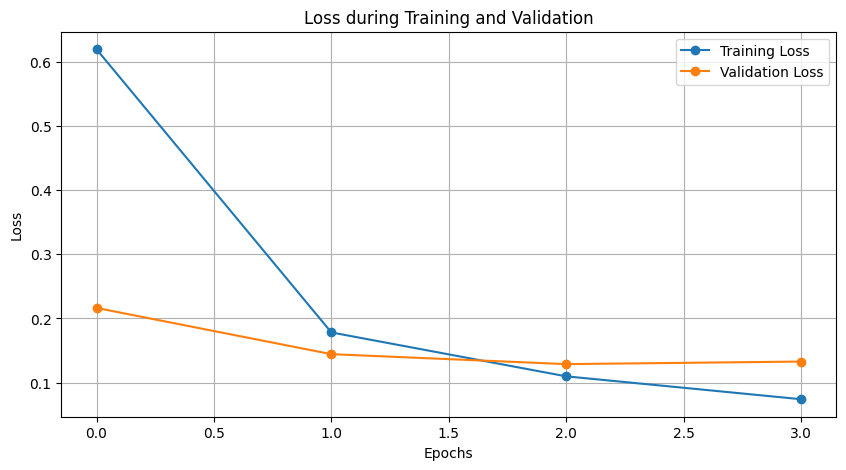

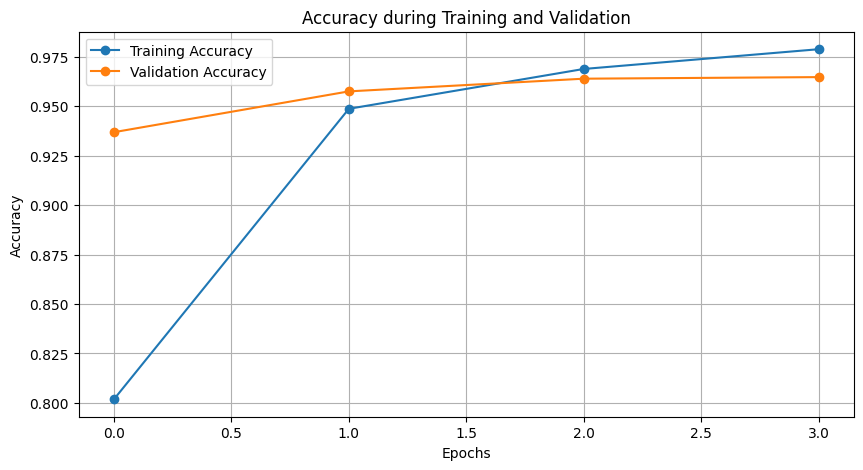

In [23]:
cs5814_history = cs5814_model.fit(
    cs5814_X_train,
    cs5814_y_train,
    validation_split=0.2,
    epochs=cs5814_epochs,
    batch_size=cs5814_batch_size,
    callbacks=[cs5814_early_stopping]
)

cs5814_y_pred = cs5814_model.predict(cs5814_X_test)
cs5814_y_pred_classes = np.argmax(cs5814_y_pred, axis=1)
cs5814_y_true_classes = np.argmax(cs5814_y_test, axis=1)

print("Classification Report:")
print(classification_report(cs5814_y_true_classes, cs5814_y_pred_classes))

plt.figure(figsize=(10, 5))
plt.plot(cs5814_history.history['loss'], marker='o', label='Training Loss')
plt.plot(cs5814_history.history['val_loss'], marker='o', label='Validation Loss')
plt.title('Loss during Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(cs5814_history.history['accuracy'], marker='o', label='Training Accuracy')
plt.plot(cs5814_history.history['val_accuracy'], marker='o', label='Validation Accuracy')
plt.title('Accuracy during Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

###DistilBERT

In [1]:
torch.manual_seed(42)
np.random.seed(42)

In [2]:
class cs5814_PersonalityDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.encodings = tokenizer(
            texts.tolist(),
            truncation=True,
            padding=True,
            max_length=max_len,
            return_tensors='pt'
        )
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

In [3]:
def cs5814_train_model(model, train_loader, val_loader, device, epochs=3):
    optimizer = AdamW(model.parameters(), lr=5e-5)
    cs5814_train_losses, cs5814_val_losses, cs5814_val_accuracies = [], [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        cs5814_train_losses.append(avg_train_loss)

        model.eval()
        val_loss, val_preds, val_true = 0, [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                val_loss += loss.item()

                _, preds = torch.max(outputs.logits, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        cs5814_val_losses.append(avg_val_loss)

        val_accuracy = accuracy_score(val_true, val_preds)
        cs5814_val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, Val Accuracy = {val_accuracy:.4f}")

    return cs5814_train_losses, cs5814_val_losses, cs5814_val_accuracies


def cs5814_plot_metrics(cs5814_train_losses, cs5814_val_losses, cs5814_val_accuracies):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(cs5814_train_losses, marker='o', label="Train Loss")
    plt.plot(cs5814_val_losses, marker='o', label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(cs5814_val_accuracies, marker='o', label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train Loss = 1.8035, Val Loss = 1.3681, Val Accuracy = 0.5936
Epoch 2: Train Loss = 1.0888, Val Loss = 1.0600, Val Accuracy = 0.6827
Epoch 3: Train Loss = 0.7041, Val Loss = 0.9459, Val Accuracy = 0.7236


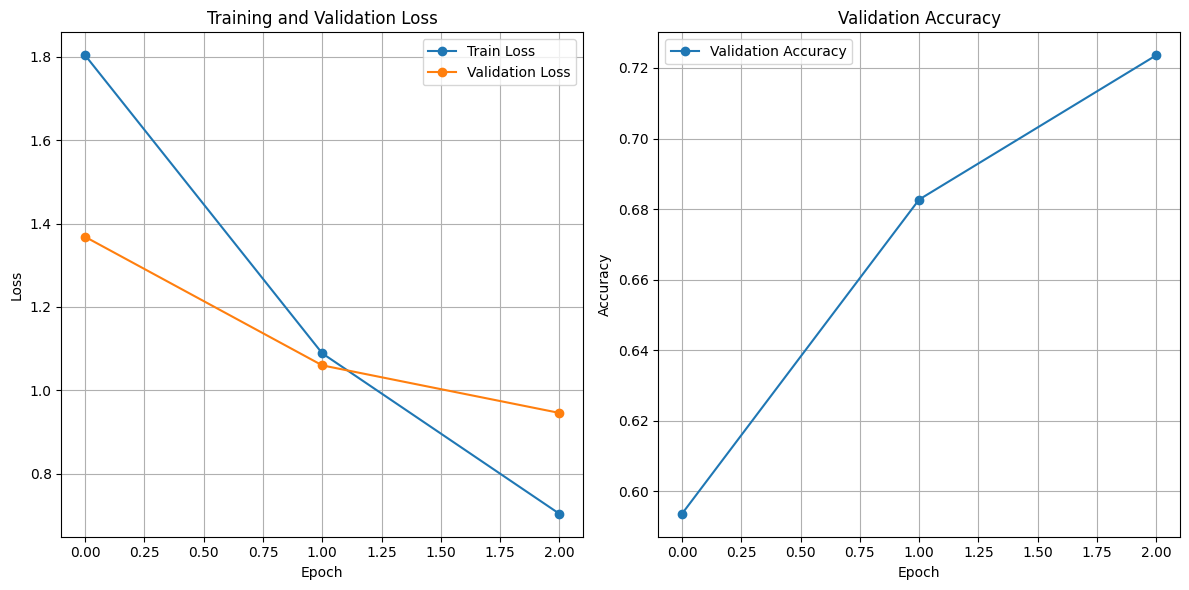


Classification Report:
              precision    recall  f1-score   support

        ENFJ       0.73      0.84      0.78       628
        ENFP       0.68      0.51      0.58       658
        ENTJ       0.72      0.72      0.72       624
        ENTP       0.55      0.50      0.52       618
        ESFJ       0.99      0.99      0.99       634
        ESFP       0.96      0.99      0.98       641
        ESTJ       0.94      0.98      0.96       604
        ESTP       0.86      0.89      0.88       603
        INFJ       0.48      0.43      0.45       610
        INFP       0.40      0.60      0.48       650
        INTJ       0.62      0.29      0.40       585
        INTP       0.44      0.46      0.45       599
        ISFJ       0.83      0.99      0.90       641
        ISFP       0.77      0.91      0.83       622
        ISTJ       0.91      0.79      0.85       626
        ISTP       0.73      0.66      0.69       657

    accuracy                           0.72     10000
  

In [4]:
def main():
    cs5814_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/balanced_mbti_data.csv')
    cs5814_df = cs5814_df.sample(n=50000, random_state=42)
    cs5814_label_encoder = LabelEncoder()
    cs5814_df['encoded_type'] = cs5814_label_encoder.fit_transform(cs5814_df['type'])

    cs5814_train_texts, cs5814_val_texts, cs5814_train_labels, cs5814_val_labels = train_test_split(
        cs5814_df['posts'],
        cs5814_df['encoded_type'],
        test_size=0.2,
        random_state=42
    )

    cs5814_train_labels = cs5814_train_labels.values
    cs5814_val_labels = cs5814_val_labels.values

    cs5814_MODEL_NAME = 'distilbert-base-uncased'
    cs5814_tokenizer = DistilBertTokenizer.from_pretrained(cs5814_MODEL_NAME)
    cs5814_model = DistilBertForSequenceClassification.from_pretrained(
        cs5814_MODEL_NAME,
        num_labels=len(cs5814_label_encoder.classes_)
    )

    cs5814_train_dataset = cs5814_PersonalityDataset(cs5814_train_texts, cs5814_train_labels, cs5814_tokenizer)
    cs5814_val_dataset = cs5814_PersonalityDataset(cs5814_val_texts, cs5814_val_labels, cs5814_tokenizer)
    cs5814_train_loader = DataLoader(cs5814_train_dataset, batch_size=16, shuffle=True)
    cs5814_val_loader = DataLoader(cs5814_val_dataset, batch_size=16)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    cs5814_model.to(device)

    cs5814_train_losses, cs5814_val_losses, cs5814_val_accuracies = cs5814_train_model(
        cs5814_model,
        cs5814_train_loader,
        cs5814_val_loader,
        device,
        epochs=3
    )

    cs5814_plot_metrics(cs5814_train_losses, cs5814_val_losses, cs5814_val_accuracies)

    cs5814_model.eval()
    cs5814_val_preds, cs5814_val_true = [], []
    with torch.no_grad():
        for batch in cs5814_val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = cs5814_model(input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)

            cs5814_val_preds.extend(preds.cpu().numpy())
            cs5814_val_true.extend(batch['labels'].numpy())

    print("\nClassification Report:")
    print(classification_report(
        cs5814_val_true,
        cs5814_val_preds,
        target_names=cs5814_label_encoder.classes_
    ))

if __name__ == '__main__':
    main()

###Model Comparison

Note: The comparison graphs of the models were plotted by manually entering the validation loss and validation accuracy scores. Unfortunately, the notebook crashed multiple times during execution, preventing us from retrieving the variables containing these metrics directly after running all the models. This issue arose due to the limited memory and GPU capacity available in Colab, which caused the Colab GPUs to reach their limits during the experiments. If you want then you can check the corresponding model accuracies and loss values from the code above. Thankyou for understanding.

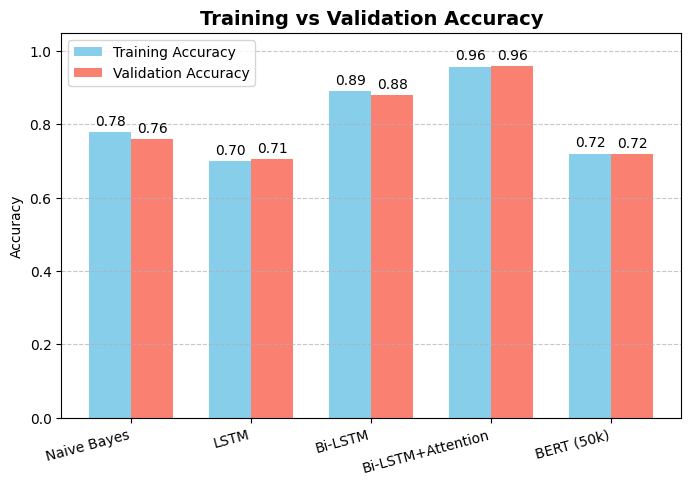

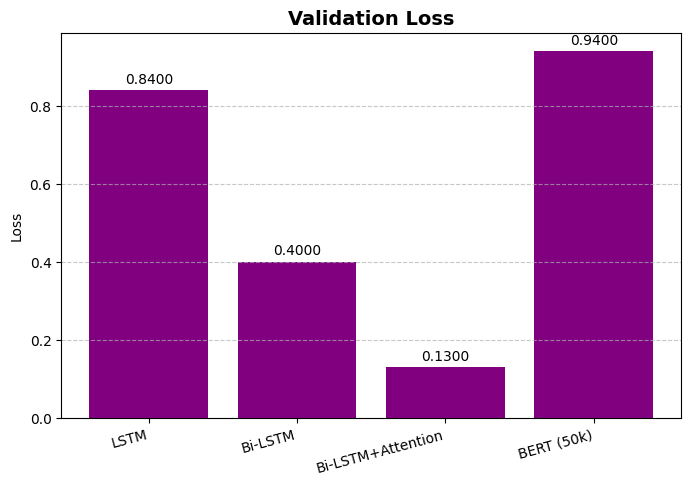

In [5]:
models = ["Naive Bayes", "LSTM", "Bi-LSTM", "Bi-LSTM+Attention", "BERT (50k)"]
validation_accuracy = [0.76, 0.7058, 0.88, 0.96, 0.72]
training_accuracy = [0.78, 0.7001, 0.8903, 0.9581, 0.7208]
validation_loss = [None, 0.84, 0.40, 0.13, 0.94]

validation_loss = [np.nan if v is None else v for v in validation_loss]

# ------------------ Plot 1: Training vs Validation Accuracy ------------------
fig1, ax1 = plt.subplots(figsize=(8, 5))

x = np.arange(len(models))
width = 0.35

bars_train = ax1.bar(x - width/2, training_accuracy, width, label='Training Accuracy', color='skyblue')
bars_val   = ax1.bar(x + width/2, validation_accuracy, width, label='Validation Accuracy', color='salmon')

ax1.set_title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=15, ha='right')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0, 1.05])
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.legend()

# Add value labels on top of bars
for bar in bars_train:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.2f}',
             ha='center', va='bottom', fontsize=10)

for bar in bars_val:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.2f}',
             ha='center', va='bottom', fontsize=10)

if use_cursors:
    cursor1 = mplcursors.cursor(bars_train + bars_val, hover=True)
    @cursor1.connect("add")
    def on_add(sel):
        bar = sel.artist
        height = bar.get_height()
        x_val = bar.get_x() + bar.get_width()/2
        idx = np.argmin(np.abs(x - x_val))  # nearest model index
        metric = "Training Accuracy" if bar in bars_train else "Validation Accuracy"
        sel.annotation.set_text(f'{models[idx]}\n{metric}: {height:.2f}')
        sel.annotation.get_bbox_patch().set(fc="lightyellow", alpha=0.8)


# ------------------ Plot 2: Validation Loss ------------------
fig2, ax2 = plt.subplots(figsize=(8, 5))

bars_loss = ax2.bar(models, validation_loss, color='purple')

ax2.set_title('Validation Loss', fontsize=14, fontweight='bold')
ax2.set_ylabel('Loss')
ax2.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=15, ha='right')

for bar in bars_loss:
    height = bar.get_height()
    if not np.isnan(height):
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.4f}',
                 ha='center', va='bottom', fontsize=10)

if use_cursors:
    cursor2 = mplcursors.cursor(bars_loss, hover=True)
    @cursor2.connect("add")
    def on_add_loss(sel):
        bar = sel.artist
        height = bar.get_height()
        # Determine which model from x position
        x_val = bar.get_x() + bar.get_width()/2
        idx = int(np.round(x_val)) if 0 <= np.round(x_val) < len(models) else None
        model_name = models[idx] if idx is not None else "Unknown Model"
        sel.annotation.set_text(f'{model_name}\nValidation Loss: {height:.4f}')
        sel.annotation.get_bbox_patch().set(fc="lightyellow", alpha=0.8)

plt.show()
